# In fig below , ~11 yr periodicity can be noticed. The current periodic cycle is cycle 25th, it hasn't reached it's peak value. Our goal is to predict the peak of that cycle. We want to test our model by predicting peaks of previous cycles.

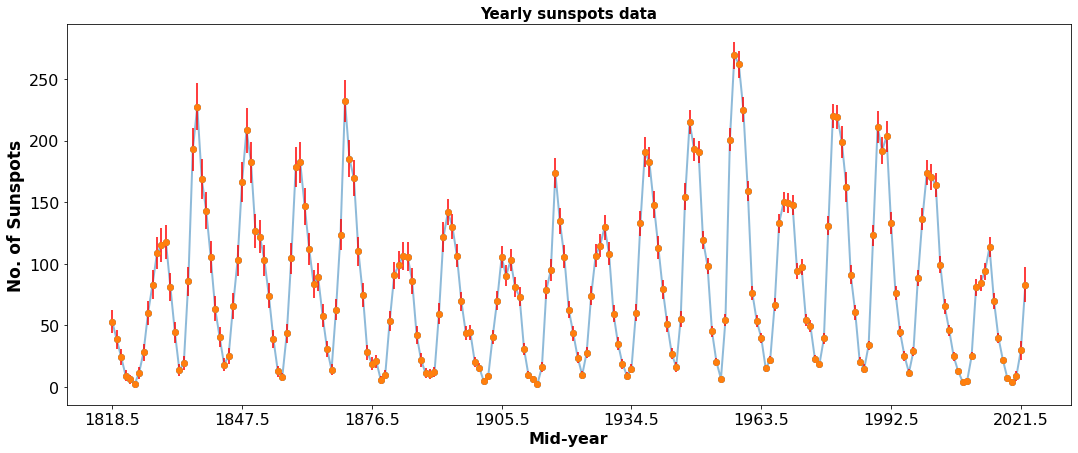

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


R_2 = []                                   #    R-squared values
pear = []                                  # perason's correlation values



df = pd.read_csv('/home/babyhulk/Downloads/yearly_sun.csv',sep=';',header=None)

# clipping time series

df = df[118:]                                          # observations before yr 1818 donot have error bars


plt.figure(figsize=(18,7))
plt.plot(df[0],df[1],lw=2,alpha=0.5)
plt.scatter(df[0],df[1])
plt.errorbar(df[0],df[1],yerr=df[2],fmt='o',ecolor='r')
plt.xlabel("Mid-year",fontsize=16,weight='bold')
plt.ylabel("No. of Sunspots",fontsize=17,weight='bold')
plt.title("Yearly sunspots data",fontsize=15,weight='bold')
t=np.linspace(1818.5,2021.5,29)
axis = []
for i in range(0,29):

  if i%4==0:
    axis.append(t[i])

plt.xticks(axis,fontsize=16)
plt.yticks(fontsize=16)
plt.show()




# Identifying sunspot minima and maxima points


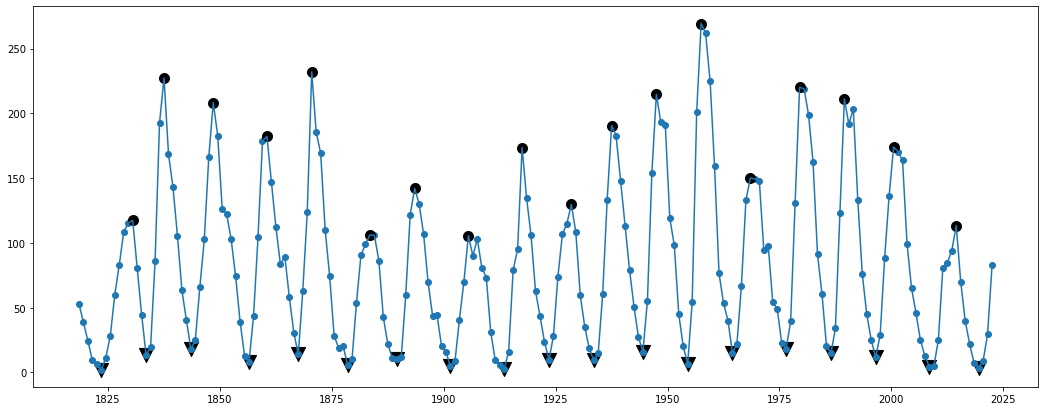

In [2]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ExpSineSquared,WhiteKernel,Matern
import sklearn.metrics
from scipy.stats import ks_2samp


df = pd.read_csv('/home/babyhulk/Downloads/yearly_sun.csv',sep=';',header=None)
df = df[118:]
ssn = np.array(df[1])
date = np.array(df[0])
err = np.array(df[2])
ssn_lvl = np.zeros(len(ssn[ssn<20]))     # defining baseline to reveal troughs in sunspot time-series
a = 0
date_lvl = np.zeros(len(ssn[ssn<20]))
err_lvl = np.zeros(len(ssn[ssn<20]))


for i in range(0,len(ssn)):
  if ssn[i] < 20 :
    ssn_lvl[a] = ssn[i]
    date_lvl[a] = date[i]
    err_lvl[a] = err[i]
    a = a+1
# print(ssn_lvl)

a=0
cluster = []         # breaking ssn in tiny nearby clusters to select minimum ssn out of them
d = []
e = []
ssn_min = []
date_min = []
err_min = []


for i in range(0,len(ssn_lvl)-1):
  if date_lvl[i+1]-date_lvl[i]<6:
    cluster.append(ssn_lvl[i])
    d.append(date_lvl[i])
    e.append(err_lvl[i])
    if i == (len(ssn_lvl)-2):
      ssn_min.append(np.min(cluster))
      # print((np.where(cluster==np.min(cluster)))[0])
      date_min.append(d[np.array((np.where(cluster==min(cluster)))[0]).item()])
      err_min.append(e[np.array((np.where(np.array(cluster)==np.min(cluster)))[0]).item()])
  else:
    cluster.append(ssn_lvl[i])
    d.append(date_lvl[i])
    e.append(err_lvl[i])
    # print(np.array((np.where(cluster==min(cluster)))[0]))
    if len((np.where(cluster==min(cluster)))[0])>1:                ### if there are multiple minima values 
      #  print((np.where(cluster==min(cluster))[0][1]),i)
      date_min.append(d[np.array((np.where(cluster==min(cluster)))[0][1]).item()])
      err_min.append(e[np.array((np.where(cluster==min(cluster)))[0][1]).item()])
      ssn_min.append(cluster[np.array((np.where(cluster==min(cluster)))[0][1]).item()])
    else:
      ssn_min.append(min(cluster))
      date_min.append(d[np.array((np.where(cluster==min(cluster)))[0]).item()])
      err_min.append(e[np.array((np.where(cluster==min(cluster)))[0]).item()])
      # date_min.append(d[np.array((np.where(cluster==min(cluster)))[0]).item()])
    cluster = []         # breaking ssn in tiny nearby clusters to select minimum ssn out of them
    d = []
    e = []

plt.figure(figsize=(18,7))
plt.scatter(date_min,ssn_min,marker="v",s=200,color='k')
plt.scatter(date,ssn)
plt.plot(date,ssn)


################################################### finding SSN maxima

ssn_max = []
date_max = []
err_max=[]
s = np.array(ssn)
d = np.array(date)
e = np.array(err)

for i in range(0,len(date_min)-1):
  chunk = ssn[(np.array((np.where(d==date_min[i]))[0])).item():(np.array((np.where(d==date_min[i+1]))[0])).item()]
  chunk_date = date[(np.array((np.where(d==date_min[i]))[0])).item():(np.array((np.where(d==date_min[i+1]))[0])).item()]
  ssn_max.append(max(chunk))
  date_max.append(chunk_date[np.array(((np.where(chunk==max(chunk))[0])[0])).item()])
  err_max.append(err[np.array(((np.where(s==max(chunk))[0])[0])).item()])
 
    
plt.scatter(date_max,ssn_max,s=100,color='k')



# Applying GPR : Instead of testing our model by predicting a full cycle, 2 extra data points (=2yrs observation) after the minimum is added to the training data. This is done because i tried predicting the whole cycle, but the models fail to provide accurate and practically usable predictions.

1) The minimum bound for the hyperparameters  = the shortest time difference between observations (1 year)          
2) The maximum bound for the hyperparameters  = the total time span of observations (depends on each testing)      
3) Scikit learn provides a parameter called "Normalization" , Which divides the data by the its standard deviation. But the error values are not standardised, I noticed         this because the model wasn't fitted well if i donot divide the errors by the standard deviation of the data.

In [26]:
min_l = 1           # redundant values, used just to bypass error of " min_l, max_l not defined"
max_l = 2

kernel_list = [(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+( ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+( ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+( ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+( ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13)))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(7,13))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)]


193 12
1**2 * RBF(length_scale=9.66) * ExpSineSquared(length_scale=1.31, periodicity=10.8)
likelihood =  -8.135729727720509e+01


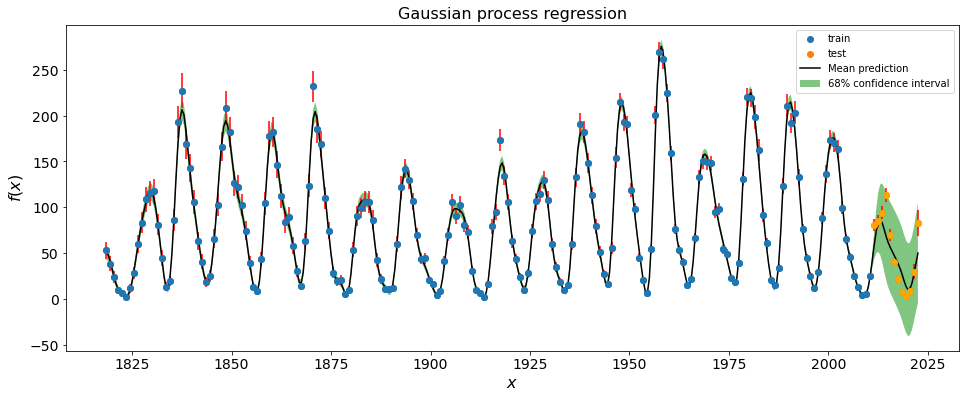

24th percentage error :  [-39.65727228]
190
181 9


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.991**2 * RBF(length_scale=9.78) * ExpSineSquared(length_scale=1.27, periodicity=10.8)
likelihood =  -8.035452872546702e+01


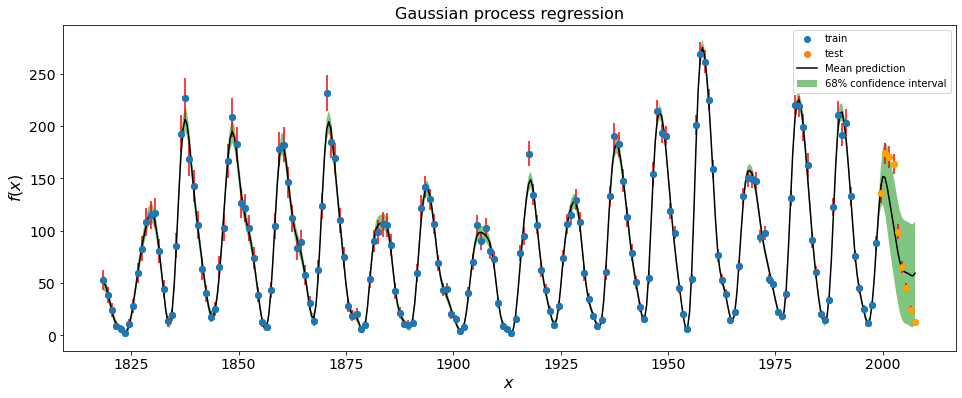

24th percentage error :  [-13.1958766]
178
171 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


1.06**2 * RBF(length_scale=9.91) * ExpSineSquared(length_scale=1.29, periodicity=10.9)
likelihood =  -7.86935838536772e+01


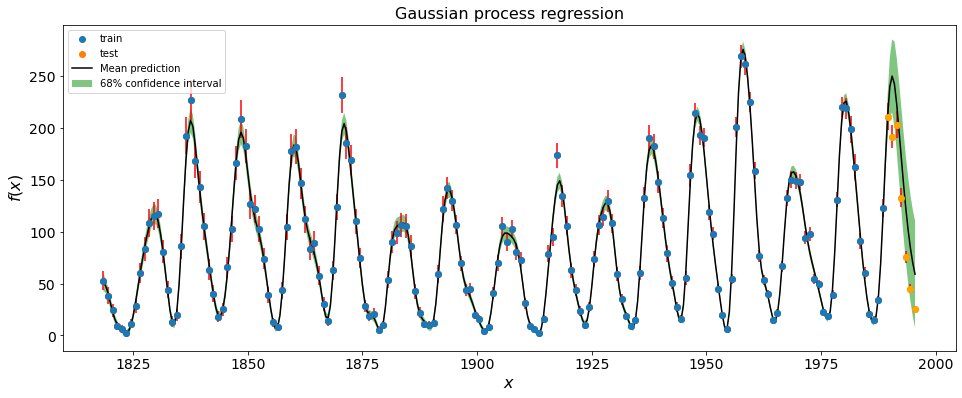

24th percentage error :  [-0.42899439]
168
161 7
1.03**2 * RBF(length_scale=9.77) * ExpSineSquared(length_scale=1.26, periodicity=11.1)
likelihood =  -7.641297572710045e+01


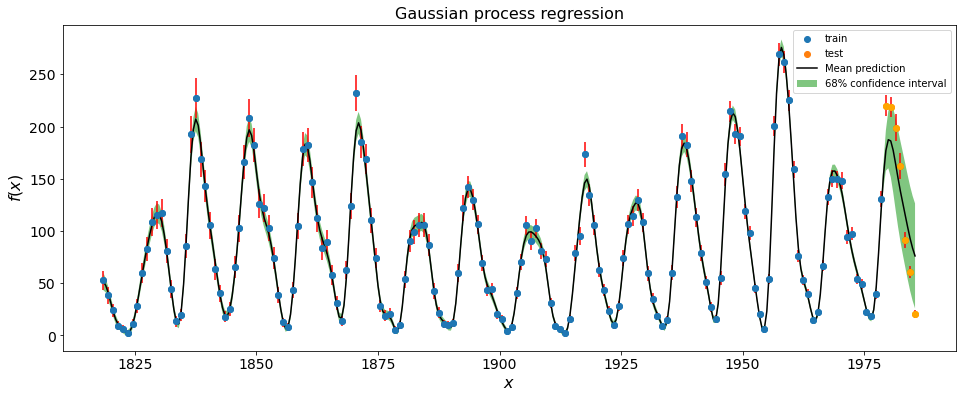

24th percentage error :  [-19.53916674]
158
149 9
1.04**2 * RBF(length_scale=10.4) * ExpSineSquared(length_scale=1.27, periodicity=11.2)
likelihood =  -5.945268947976422e+01


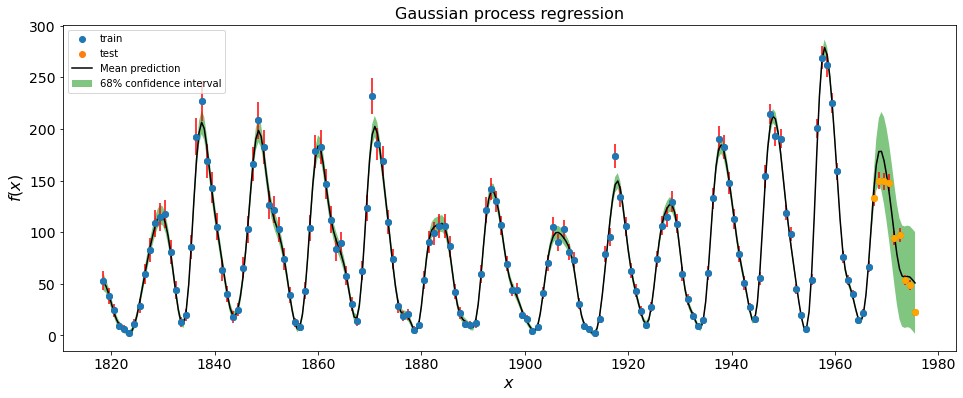

24th percentage error :  [18.80034777]
146
139 7
1.23**2 * RBF(length_scale=10.5) * ExpSineSquared(length_scale=1.34, periodicity=11.2)
likelihood =  -6.574684808216062e+01


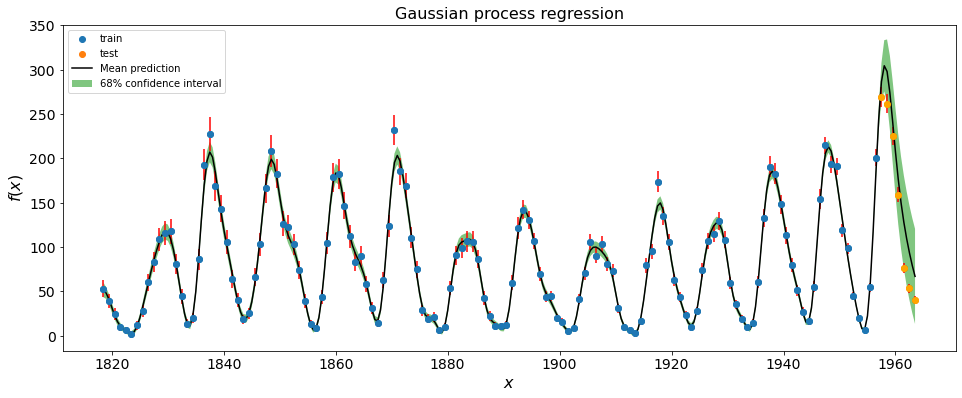

24th percentage error :  [6.3846985]
136
129 7
1.15**2 * RBF(length_scale=10.4) * ExpSineSquared(length_scale=1.33, periodicity=11.4)
likelihood =  -5.396520883953869e+01


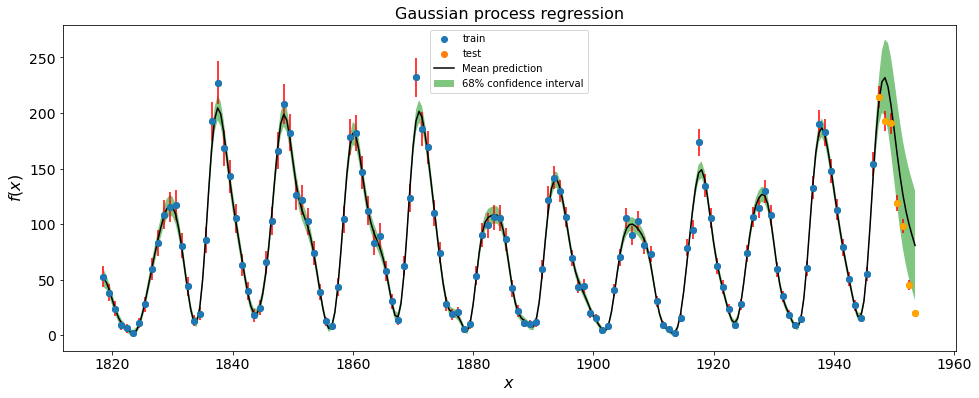

24th percentage error :  [-1.75273862]
193 12


/tmp/ipykernel_18178/833785099.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter([], [], label="1 sigma error",color='g',marker="o")
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 5e+00. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1.21**2 * RBF(length_scale=32.9) * ExpSineSquared(length_scale=1.87, periodicity=10.9) + 0.441**2 * RBF(length_scale=1.72) * ExpSineSquared(length_scale=5.07, periodicity=5)
likelihood =  -7.196925581409837e+01


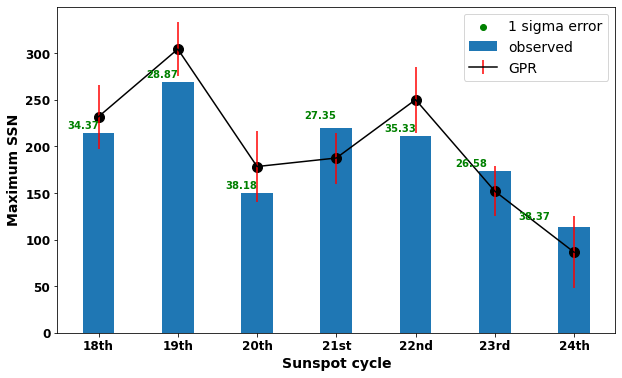

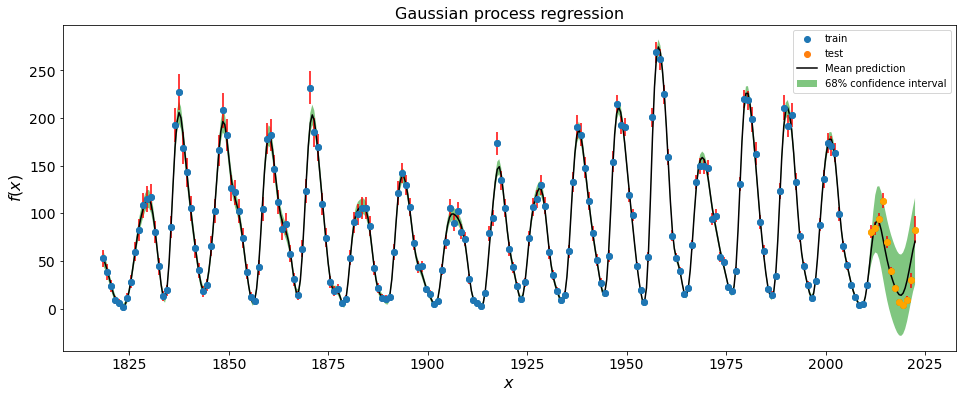

24th percentage error :  [-36.36192378]
190
181 9
0.463**2 * RBF(length_scale=6.54) * ExpSineSquared(length_scale=1.07, periodicity=9.94) + 1.17**2 * RBF(length_scale=31.3) * ExpSineSquared(length_scale=1.72, periodicity=11)
likelihood =  -6.793740432932674e+01


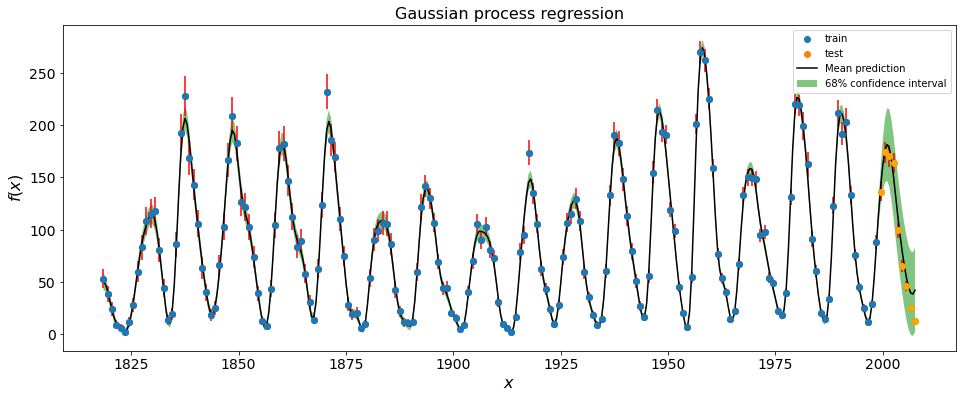

24th percentage error :  [0.97002663]
178
171 7
1.21**2 * RBF(length_scale=32.3) * ExpSineSquared(length_scale=1.69, periodicity=11) + 0.481**2 * RBF(length_scale=6.52) * ExpSineSquared(length_scale=1.12, periodicity=9.91)
likelihood =  -6.670419674521928e+01


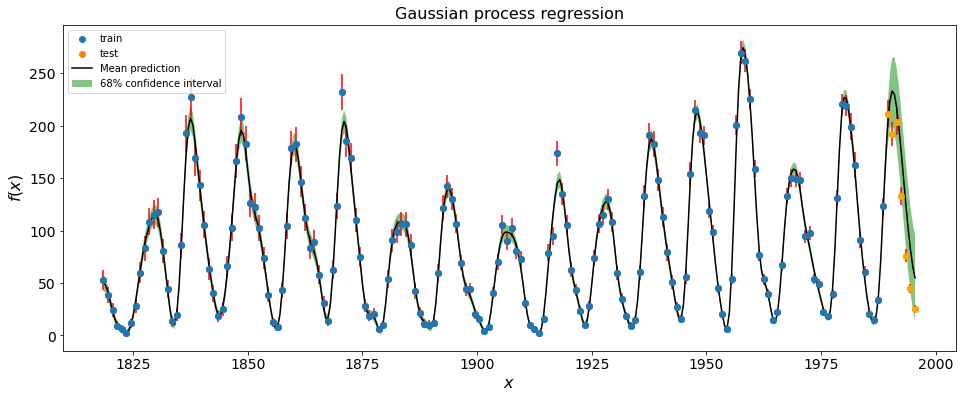

24th percentage error :  [-5.98512268]
168
161 7
1.16**2 * RBF(length_scale=26.1) * ExpSineSquared(length_scale=1.68, periodicity=10.9) + 0.397**2 * RBF(length_scale=1.49) * ExpSineSquared(length_scale=11.7, periodicity=13.5)
likelihood =  -6.791306440277242e+01


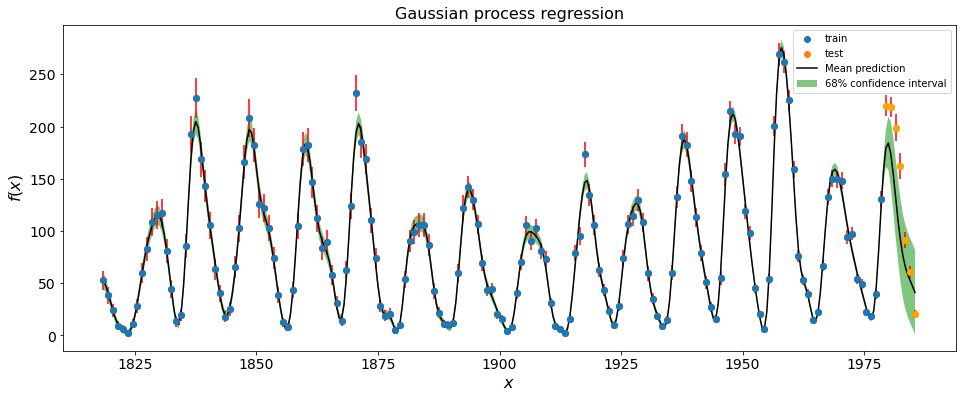

24th percentage error :  [-18.46926138]
158
149 9
0.358**2 * RBF(length_scale=1.48) * ExpSineSquared(length_scale=43.2, periodicity=10.2) + 1.22**2 * RBF(length_scale=25.3) * ExpSineSquared(length_scale=1.65, periodicity=10.8)
likelihood =  -5.3570618606291646e+01


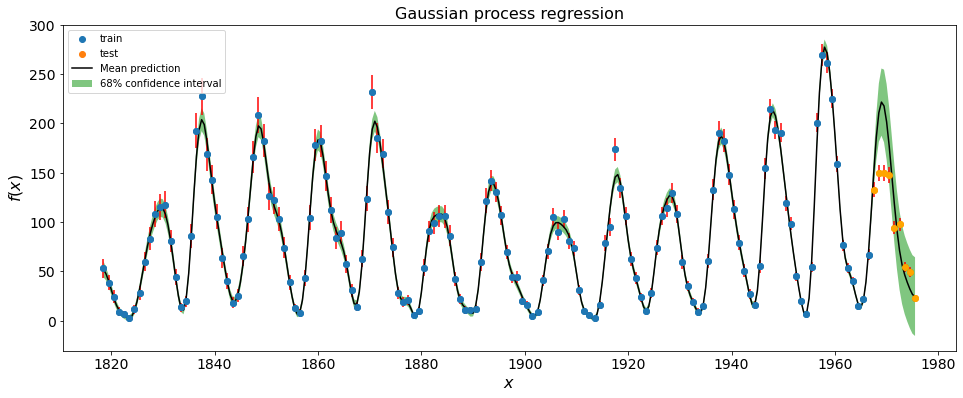

24th percentage error :  [40.59392778]
146
139 7
0.402**2 * RBF(length_scale=1.61) * ExpSineSquared(length_scale=4.79, periodicity=106) + 1.44**2 * RBF(length_scale=25.4) * ExpSineSquared(length_scale=1.66, periodicity=10.8)
likelihood =  -5.978951037072288e+01


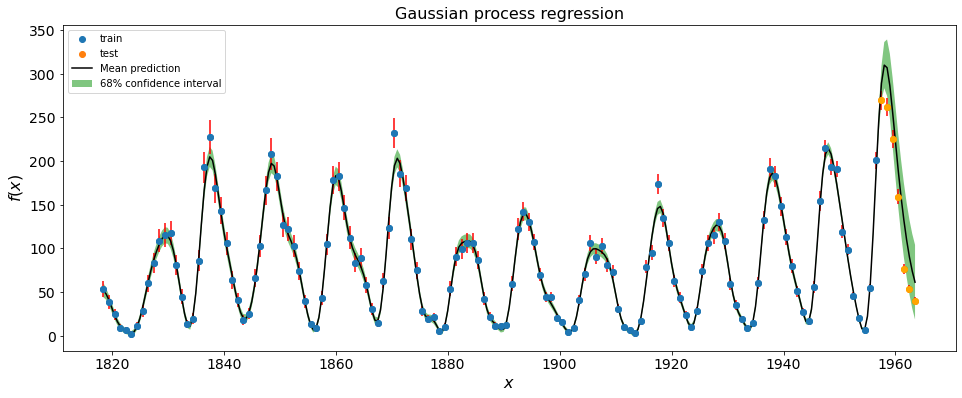

24th percentage error :  [7.27820422]
136
129 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__k2__length_scale is close to the specified upper bound 1.28e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.672**2 * RBF(length_scale=1.85) * ExpSineSquared(length_scale=11.8, periodicity=65.6) + 0.844**2 * RBF(length_scale=128) * ExpSineSquared(length_scale=1.54, periodicity=11.1)
likelihood =  -5.151327884578322e+01


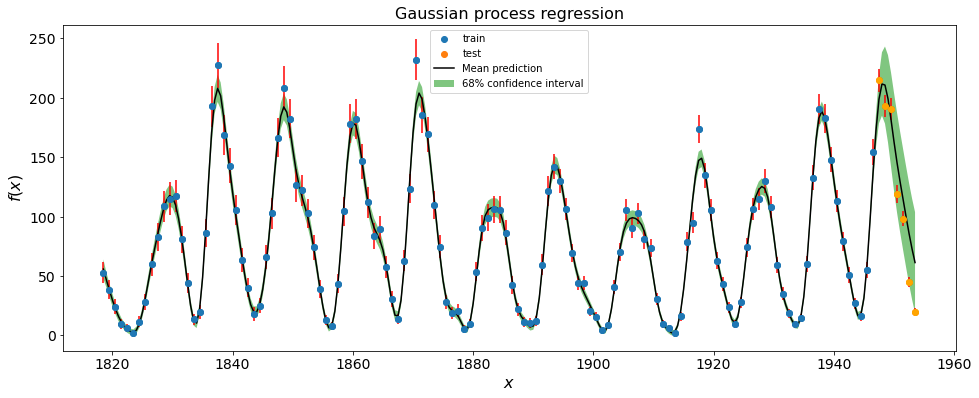

24th percentage error :  [-7.41079489]
193 12


/tmp/ipykernel_18178/833785099.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter([], [], label="1 sigma error",color='g',marker="o")
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__periodicity is close to the specified lower bound 5e+00. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklea

0.441**2 * RBF(length_scale=1.72) * ExpSineSquared(length_scale=5.07, periodicity=5) + 1.21**2 * RBF(length_scale=32.9) * ExpSineSquared(length_scale=1.87, periodicity=10.9) + 0.00316**2 * RBF(length_scale=192) * ExpSineSquared(length_scale=191, periodicity=5)
likelihood =  -7.19692659192514e+01


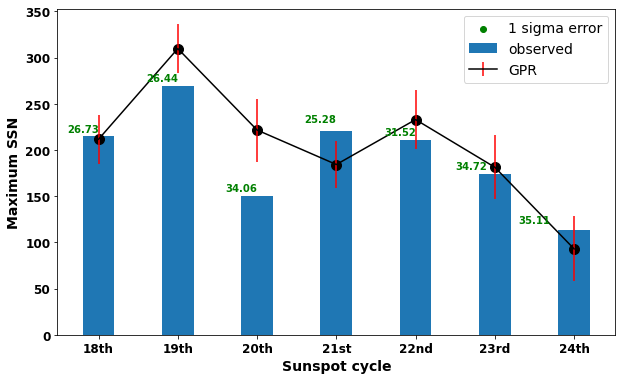

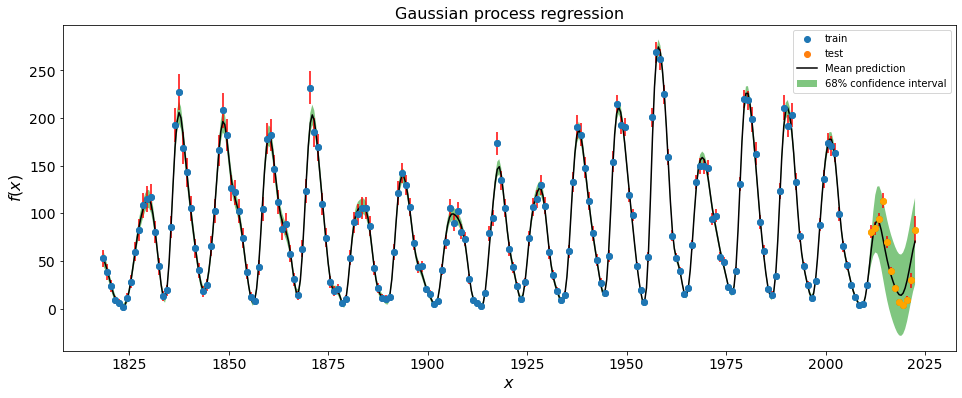

24th percentage error :  [-36.36402815]
190
181 9


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 1e+00. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__periodicity is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.102**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=5) + 1.18**2 * RBF(length_scale=32.2) * ExpSineSquared(length_scale=1.75, periodicity=10.9) + 0.423**2 * RBF(length_scale=1.68) * ExpSineSquared(length_scale=98.6, periodicity=43.2)
likelihood =  -6.914818300860884e+01


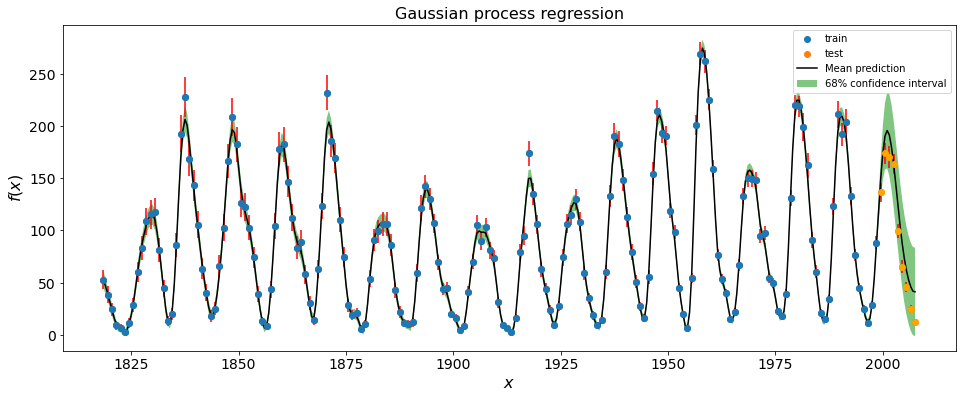

24th percentage error :  [9.35495762]
178
171 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__k2__length_scale is close to the specified lower bound 1e+00. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__periodicity is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python

1.2**2 * RBF(length_scale=31.6) * ExpSineSquared(length_scale=1.73, periodicity=10.9) + 0.104**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=5) + 0.431**2 * RBF(length_scale=1.7) * ExpSineSquared(length_scale=170, periodicity=13.3)
likelihood =  -6.742609747835661e+01


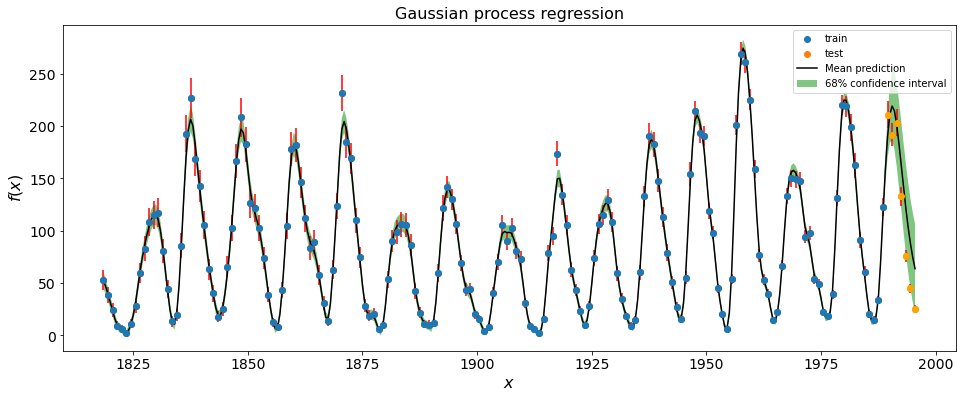

24th percentage error :  [-10.16406497]
168
161 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified upper bound 1.6e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.456**2 * RBF(length_scale=160) * ExpSineSquared(length_scale=4.86, periodicity=5.76) + 1.26**2 * RBF(length_scale=27.3) * ExpSineSquared(length_scale=1.9, periodicity=10.7) + 0.388**2 * RBF(length_scale=1.63) * ExpSineSquared(length_scale=4.54, periodicity=5)
likelihood =  -6.630109023754154e+01


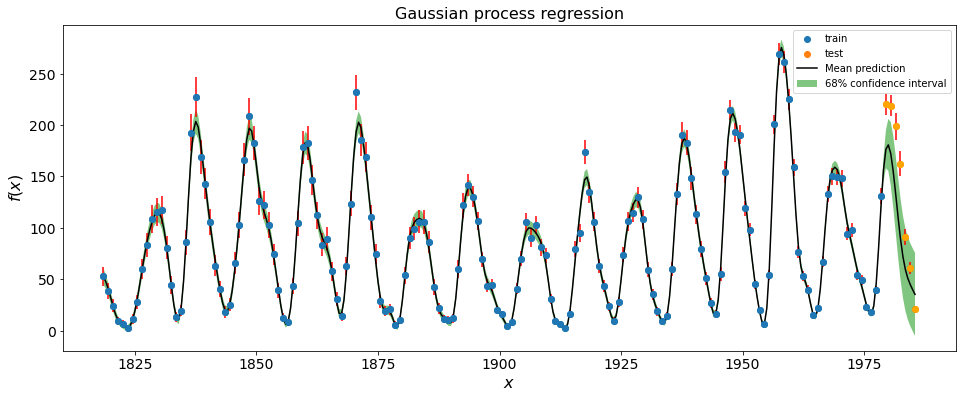

24th percentage error :  [-19.90924413]
158
149 9


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified upper bound 1.48e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.0533**2 * RBF(length_scale=148) * ExpSineSquared(length_scale=1, periodicity=6.35) + 1.2**2 * RBF(length_scale=25) * ExpSineSquared(length_scale=1.62, periodicity=10.8) + 0.363**2 * RBF(length_scale=1.53) * ExpSineSquared(length_scale=65.4, periodicity=24.4)
likelihood =  -5.3014798741983924e+01


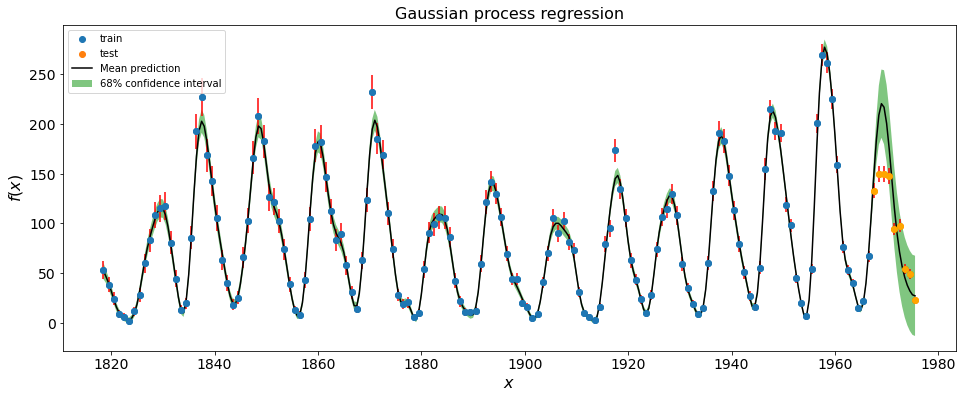

24th percentage error :  [39.29767053]
146
139 7
1.72**2 * RBF(length_scale=44.1) * ExpSineSquared(length_scale=2.26, periodicity=11.3) + 0.369**2 * RBF(length_scale=1.5) * ExpSineSquared(length_scale=100, periodicity=9.16) + 1.38**2 * RBF(length_scale=65.2) * ExpSineSquared(length_scale=2.58, periodicity=9.78)
likelihood =  -5.676871453796069e+01


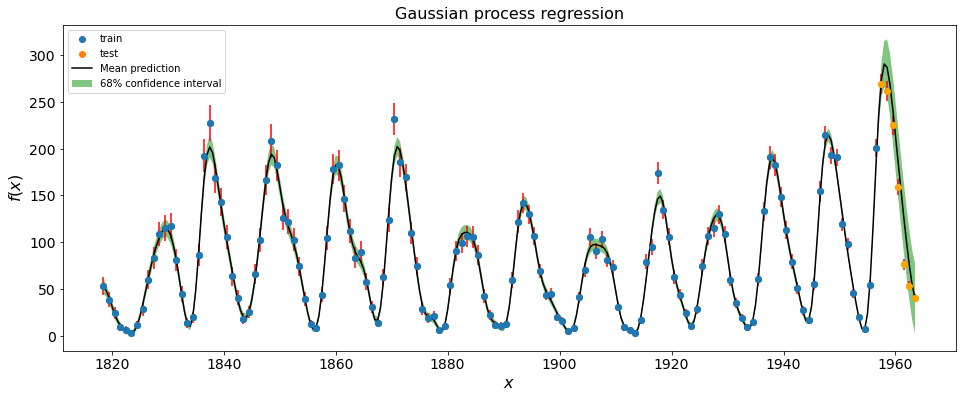

24th percentage error :  [1.8287532]
136
129 7
0.0633**2 * RBF(length_scale=1.63) * ExpSineSquared(length_scale=125, periodicity=8.26) + 1.45**2 * RBF(length_scale=30.6) * ExpSineSquared(length_scale=1.86, periodicity=11.1) + 0.424**2 * RBF(length_scale=1.63) * ExpSineSquared(length_scale=46.5, periodicity=46.4)
likelihood =  -4.8727996049233695e+01


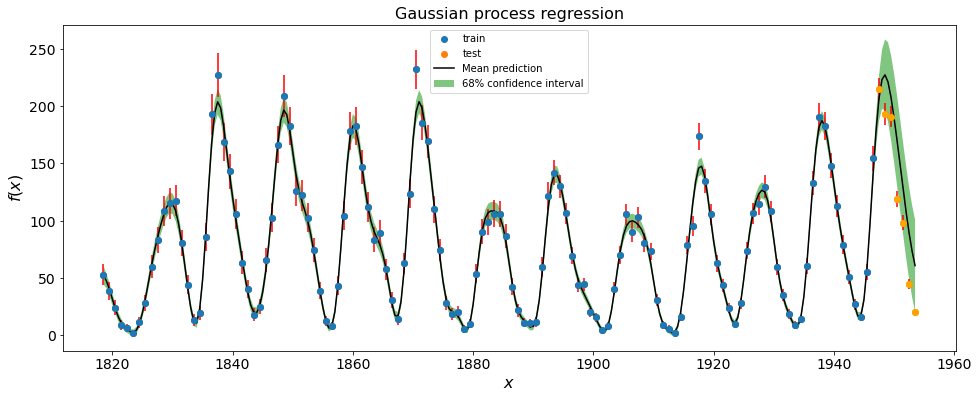

24th percentage error :  [-3.86622102]
193 12


/tmp/ipykernel_18178/833785099.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter([], [], label="1 sigma error",color='g',marker="o")
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.92e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.03**2 * RBF(length_scale=9.73) * ExpSineSquared(length_scale=1.33, periodicity=10.8) + RBF(length_scale=192)
likelihood =  -8.29643625648335e+01


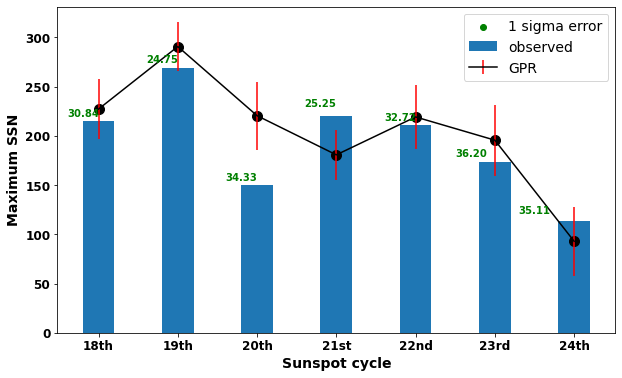

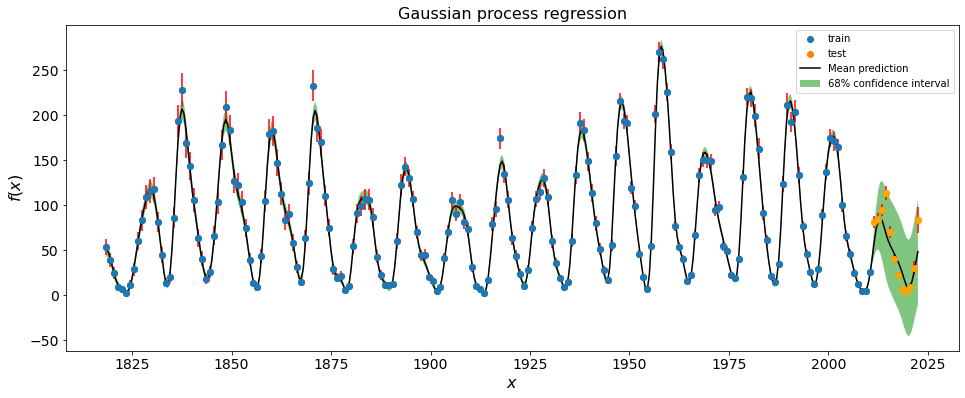

24th percentage error :  [-40.52521354]
190
181 9


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.8e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.01**2 * RBF(length_scale=9.84) * ExpSineSquared(length_scale=1.28, periodicity=10.8) + RBF(length_scale=180)
likelihood =  -8.18719759881435e+01


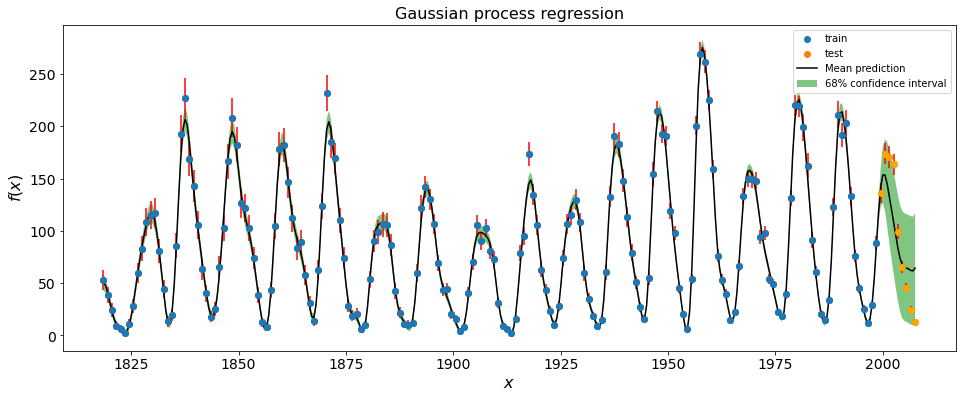

24th percentage error :  [-11.82163699]
178
171 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.7e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.08**2 * RBF(length_scale=9.99) * ExpSineSquared(length_scale=1.31, periodicity=11) + RBF(length_scale=170)
likelihood =  -8.001346636736348e+01


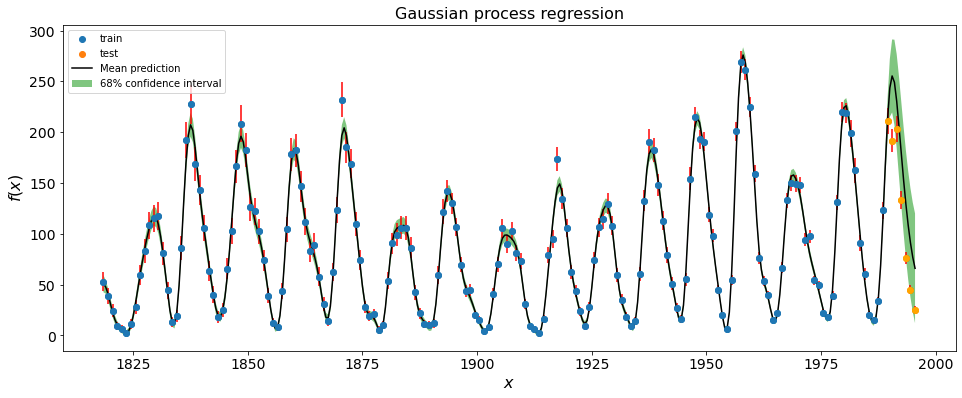

24th percentage error :  [0.55878151]
168
161 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.6e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.05**2 * RBF(length_scale=9.85) * ExpSineSquared(length_scale=1.28, periodicity=11.1) + RBF(length_scale=160)
likelihood =  -7.776687537642195e+01


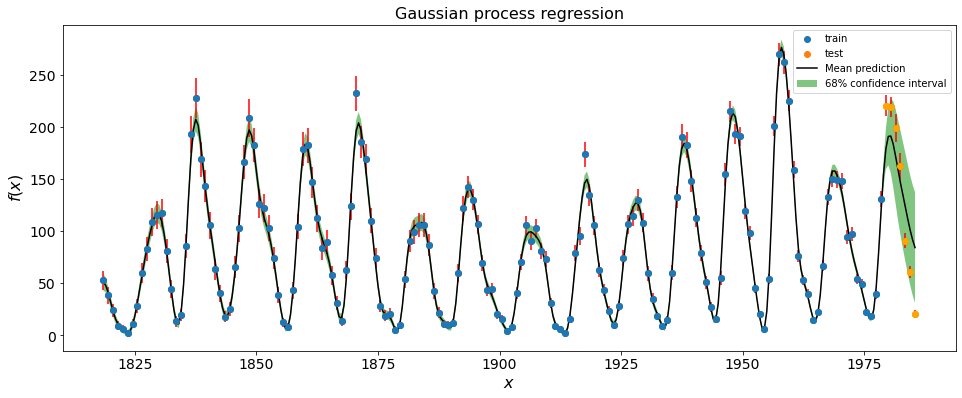

24th percentage error :  [-18.7251854]
158
149 9


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.48e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.07**2 * RBF(length_scale=10.5) * ExpSineSquared(length_scale=1.29, periodicity=11.2) + RBF(length_scale=148)
likelihood =  -6.081020301544072e+01


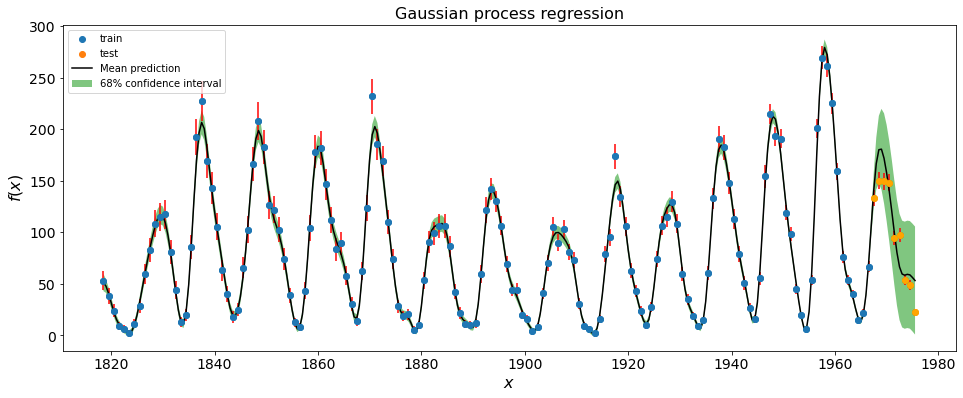

24th percentage error :  [20.07943703]
146
139 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.38e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.27**2 * RBF(length_scale=10.6) * ExpSineSquared(length_scale=1.36, periodicity=11.2) + RBF(length_scale=138)
likelihood =  -6.672385541596763e+01


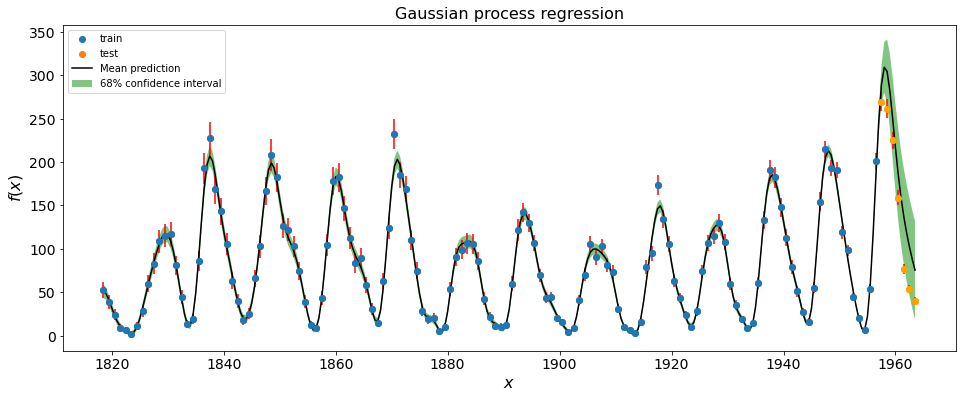

24th percentage error :  [7.48577616]
136
129 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 1.28e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.863**2 * RBF(length_scale=128) * ExpSineSquared(length_scale=1.56, periodicity=11.1) + RBF(length_scale=2.11)
likelihood =  -5.55801305617274e+01


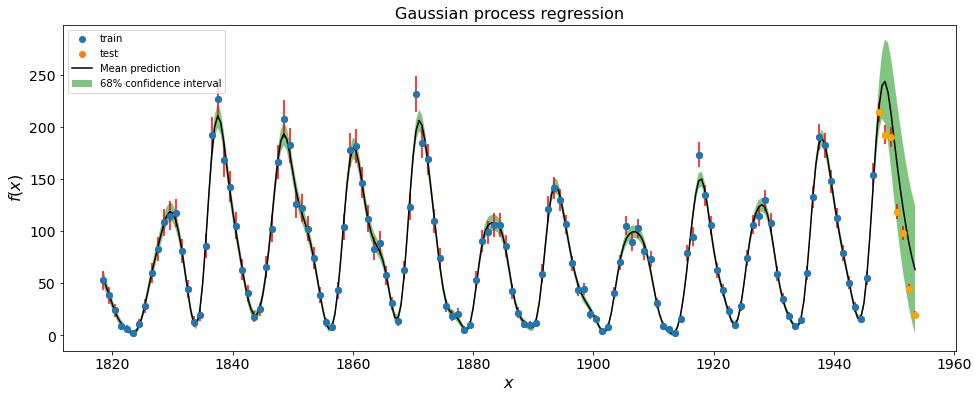

24th percentage error :  [2.1815216]
193 12


/tmp/ipykernel_18178/833785099.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter([], [], label="1 sigma error",color='g',marker="o")
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1.92e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.43**2 * RBF(length_scale=1.54) * ExpSineSquared(length_scale=5.15, periodicity=32.5) + RBF(length_scale=192) + 1.35**2 * RBF(length_scale=34.6) * ExpSineSquared(length_scale=2.04, periodicity=10.9)
likelihood =  -7.313824907017523e+01


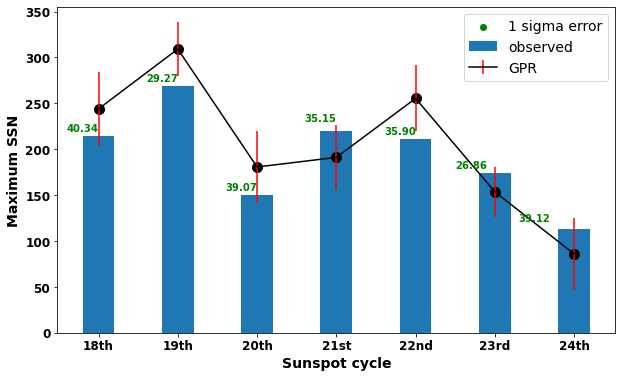

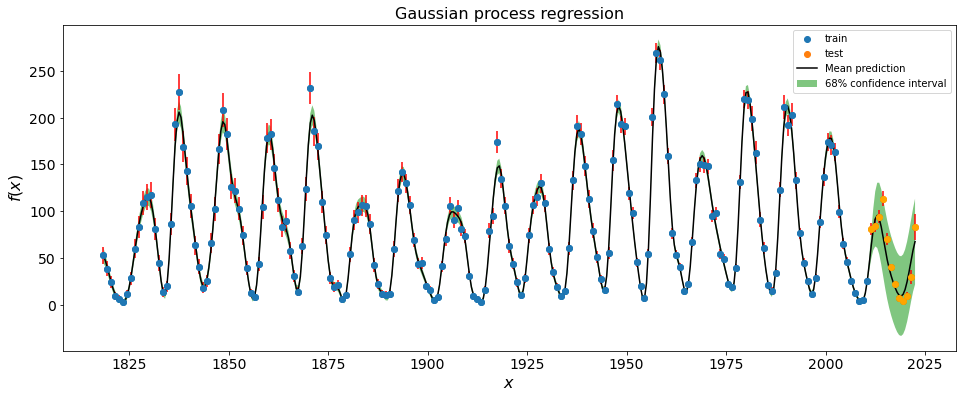

24th percentage error :  [-36.97941591]
190
181 9


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1.8e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.32**2 * RBF(length_scale=34.1) * ExpSineSquared(length_scale=1.92, periodicity=10.9) + RBF(length_scale=180) + 0.42**2 * RBF(length_scale=1.5) * ExpSineSquared(length_scale=61.6, periodicity=51)
likelihood =  -7.237233588057066e+01


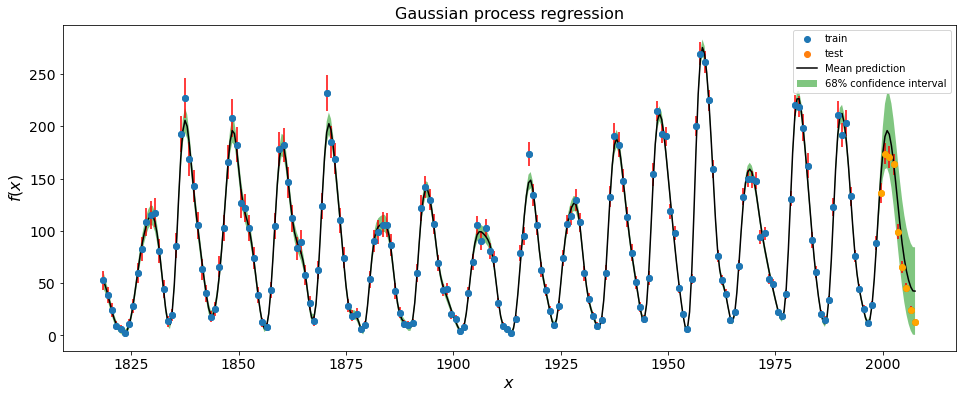

24th percentage error :  [9.4760908]
178
171 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1.7e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 5.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1.31**2 * RBF(length_scale=32.8) * ExpSineSquared(length_scale=1.83, periodicity=10.9) + RBF(length_scale=170) + 0.434**2 * RBF(length_scale=1.67) * ExpSineSquared(length_scale=4.95, periodicity=5)
likelihood =  -7.018912523081507e+01


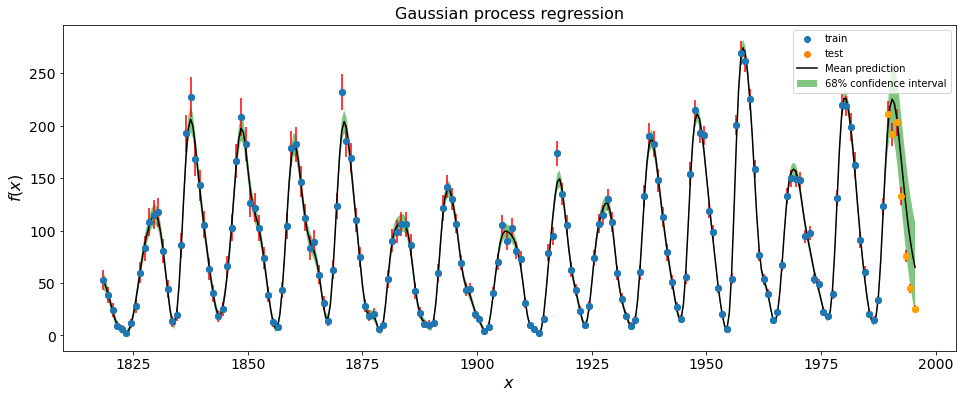

24th percentage error :  [-7.89049645]
168
161 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__periodicity is close to the specified lower bound 5e+00. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 160.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.398**2 * RBF(length_scale=1.6) * ExpSineSquared(length_scale=4.77, periodicity=5) + RBF(length_scale=160) + 1.24**2 * RBF(length_scale=26.6) * ExpSineSquared(length_scale=1.73, periodicity=10.9)
likelihood =  -6.83145373891666e+01


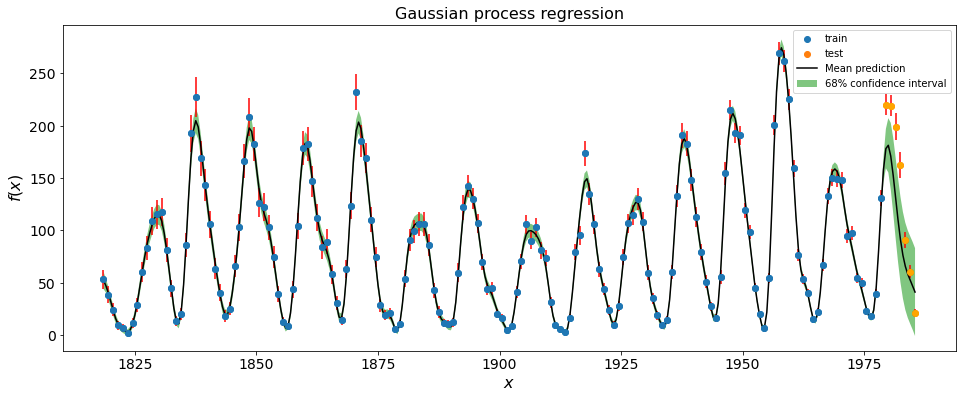

24th percentage error :  [-19.13261518]
158
149 9


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1.48e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.33**2 * RBF(length_scale=26.4) * ExpSineSquared(length_scale=1.74, periodicity=10.8) + RBF(length_scale=148) + 0.358**2 * RBF(length_scale=1.47) * ExpSineSquared(length_scale=140, periodicity=109)
likelihood =  -5.4224146198397364e+01


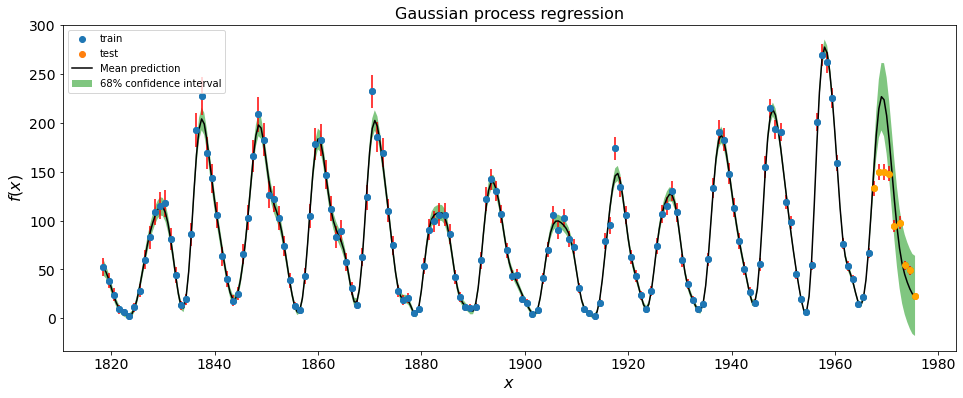

24th percentage error :  [42.83499361]
146
139 7
1.52**2 * RBF(length_scale=26.1) * ExpSineSquared(length_scale=1.71, periodicity=10.8) + RBF(length_scale=119) + 0.401**2 * RBF(length_scale=1.6) * ExpSineSquared(length_scale=11.7, periodicity=75.2)
likelihood =  -6.0241800731892724e+01


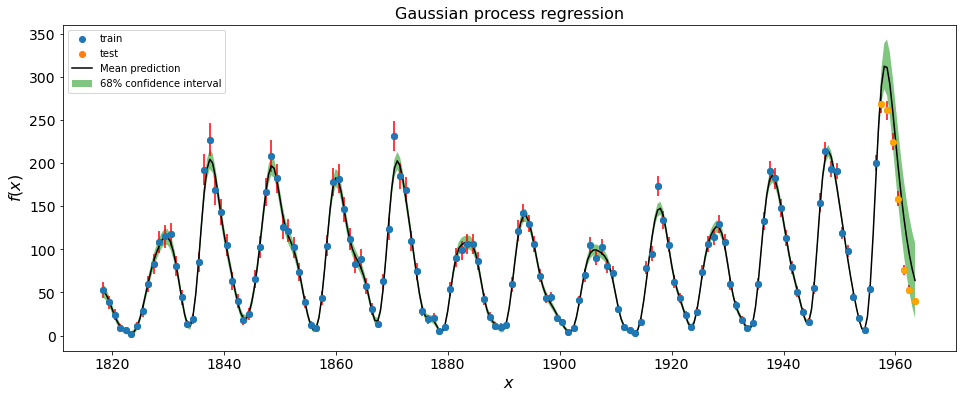

24th percentage error :  [7.93925161]
136
129 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified upper bound 1.28e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.16**2 * RBF(length_scale=128) * ExpSineSquared(length_scale=1.92, periodicity=11.1) + RBF(length_scale=36.2) + 0.6**2 * RBF(length_scale=1.78) * ExpSineSquared(length_scale=24.2, periodicity=47.4)
likelihood =  -5.091924571908798e+01


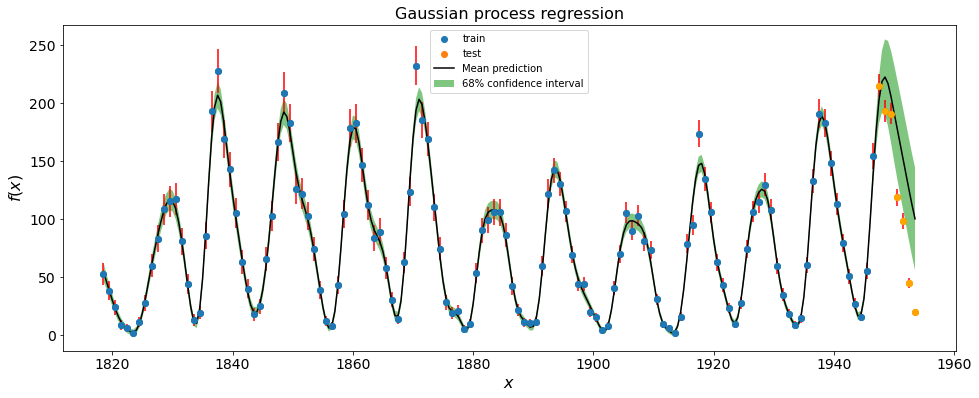

24th percentage error :  [-5.76993884]
193 12


/tmp/ipykernel_18178/833785099.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter([], [], label="1 sigma error",color='g',marker="o")
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__k2__length_scale is close to the specified upper bound 1.92e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-pa

0.332**2 * RBF(length_scale=192) * ExpSineSquared(length_scale=1, periodicity=16) + 0.377**2 * RBF(length_scale=1.51) * ExpSineSquared(length_scale=174, periodicity=18.6) + 1.31**2 * RBF(length_scale=33.2) * ExpSineSquared(length_scale=1.96, periodicity=10.9) + RBF(length_scale=192)
likelihood =  -7.023131167065762e+01


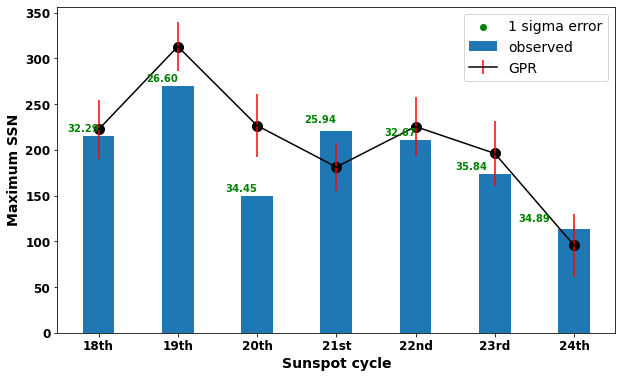

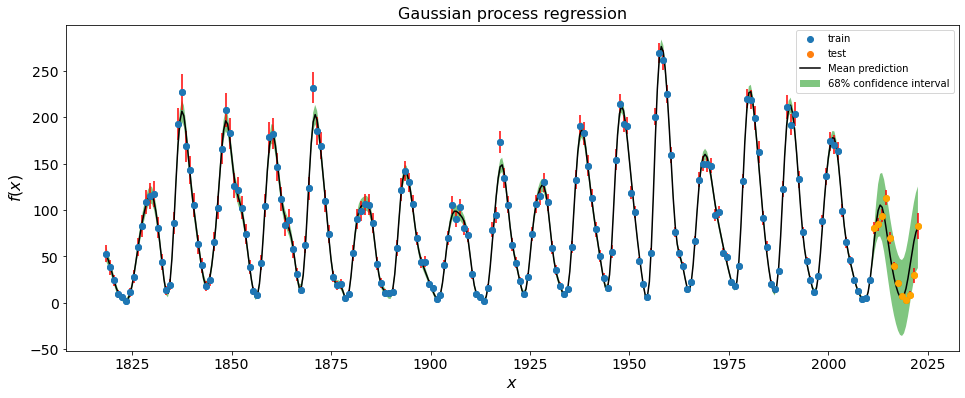

24th percentage error :  [-28.79287267]
190
181 9


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 1.8e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__periodicity is close to the specified upper bound 180.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__k2__length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda

1.28**2 * RBF(length_scale=33.5) * ExpSineSquared(length_scale=1.86, periodicity=10.9) + 0.402**2 * RBF(length_scale=1.75) * ExpSineSquared(length_scale=180, periodicity=180) + 0.166**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=7.91, periodicity=99.6) + RBF(length_scale=180)
likelihood =  -7.118031646807562e+01


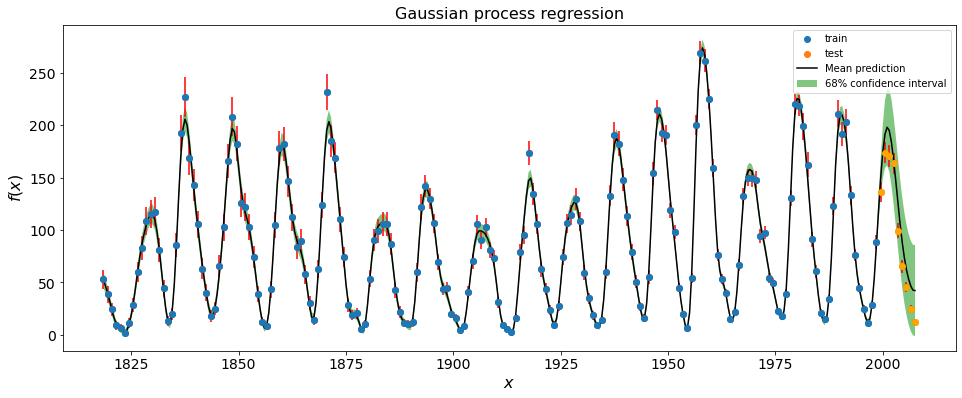

24th percentage error :  [10.15088105]
178
171 7


/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 1e+00. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/babyhulk/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 170.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.379**2 * RBF(length_scale=7.75) * ExpSineSquared(length_scale=1, periodicity=9.7) + 1.29**2 * RBF(length_scale=33) * ExpSineSquared(length_scale=1.76, periodicity=11) + 0.266**2 * RBF(length_scale=1.92) * ExpSineSquared(length_scale=5.51, periodicity=152) + RBF(length_scale=170)
likelihood =  -6.699655350861359e+01


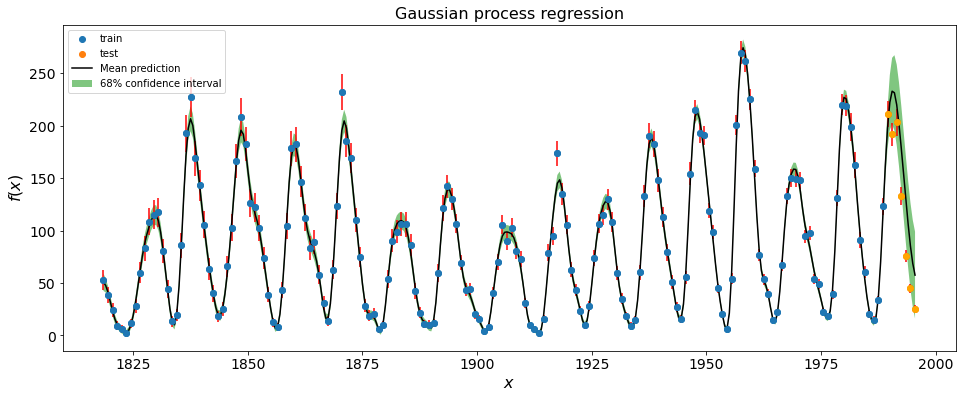

24th percentage error :  [-6.3107373]
168
161 7


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ExpSineSquared,WhiteKernel
import sklearn.metrics
from scipy.stats import ks_2samp


for j in range(0,len(kernel_list)):            # if kernel_list is not defined earlier, len(kernel_list) would throw error)
  
    x = ["24th","23rd","22nd","21st","20th","19th","18th"]   # cycle number
    height = []                                              # lists for original and predicted values
    original = []
    std = []
    gpr_peak = []
    std_peak = []

    for i in range(0,7):                                                                  #####################################
        df = pd.read_csv('/home/babyhulk/Downloads/yearly_sun.csv',sep=';',header=None)
        df = df[118:]
        if i>0:             # dropping cycles after testing data
            df = df.drop(range(df.index[df[0]==date_min[len(date_min)-1-i]][0],(df.index[df[0]== df[0].iloc[-1]][0])+1))  # data till 22 cycle
            print(len(df))
 

        df1 = df[df[0]<date_min[len(date_min)-1-(i+1)]+3]  # training data
        df2 = df[df[0]>date_min[len(date_min)-1-(i+1)]+2]  # testing data
        print(len(df1),len(df2))
        X= np.arange(df1[0].min(),df2[0].max()+0.5,0.5).reshape(-1,1)         # prediction axis
        min_l = np.array(df1[0])[1]- np.array(df1[0])[0]
        max_l = np.array(df1[0])[len(np.array(df1[0]))-1]- np.array(df1[0])[0]
        kernel_list = [(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+( ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+( ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))+RBF(length_scale=10, length_scale_bounds=(min_l,max_l))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+(1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       ,1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+1* RBF(length_scale=10,length_scale_bounds=(min_l,max_l))* ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+( ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+( ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l)))
                       , ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+ ExpSineSquared(length_scale=10,periodicity=10,length_scale_bounds=(min_l,max_l),periodicity_bounds=(5,max_l))+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)+Matern(length_scale=1.0, length_scale_bounds=(min_l,max_l), nu=1.5)]

        
        X_train=np.array(df1[0]).tolist()
        X_train  = np.array(X_train).reshape(-1,1)
        y_train=np.array(df1[1]).tolist()     
        y_train = np.array(y_train)
        y_err=(df1[2]/np.std(y_train)).tolist()                           ###  STANDARDIZING ERROR BARS        
        y_err = np.array(y_err)
        y_err_std= np.array(df1[2]).tolist()
        y_err_std = np.array(y_err_std)

        kernel = kernel_list[j]
        gaussian_process = GaussianProcessRegressor(kernel=kernel,alpha=(np.array(y_err).flatten())**2, normalize_y=True , n_restarts_optimizer=50)
        gaussian_process.fit(X_train, y_train)
        print(gaussian_process.kernel_)
        mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
        plt.figure(figsize=(16,6))
        plt.scatter(X_train, y_train, label="train")
        plt.scatter(df2[0],df2[1], label="test")
        plt.errorbar(X_train, y_train,yerr=y_err_std,fmt='o',ecolor='r',color="#1f77b4")
        plt.errorbar(df2[0], df2[1],yerr=df2[2],fmt='o',ecolor='r',color="orange")
        print("likelihood = ",gaussian_process.log_marginal_likelihood(theta=None, eval_gradient=False, clone_kernel=True))

        plt.plot(X, mean_prediction, label="Mean prediction",color='k')
        plt.fill_between(
            X.ravel(),
            mean_prediction -  std_prediction,    # multiply by 1.96 ?
            mean_prediction +  std_prediction,
            alpha=0.6,
            label=r"68% confidence interval"
        )
        plt.legend()
        plt.xlabel("$x$",fontsize=16)
        plt.ylabel("$f(x)$",fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        _ = plt.title("Gaussian process regression",fontsize=16)
        plt.show();
        
        
        
        real_max = np.array(df[1])[np.where(np.array(df[0])==date_max[len(date_max)-(i+1)])[0]][0]
        pred_max = mean_prediction[np.where(X==date_max[len(date_max)-(i+1)])[0]]
        std_max = std_prediction[np.where(X==date_max[len(date_max)-(i+1)])[0]]
        std.append(std_max)
        error_percnt = ((pred_max-real_max)*100)/real_max          # if error is +ve ----> Pred value is higher   or vice versa
        print("24th percentage error : ",error_percnt)
        height.append(pred_max)
        original.append(real_max)
        mean_pred = pd.Series(mean_prediction)
        std_pred = pd.Series(std_prediction)
        test = np.array(df2[0])
        X_sr = pd.Series(np.array(X).flatten())
        gpr_ssn = mean_pred[X_sr.index[X_sr == test[0]][0]:X_sr.index[X_sr == test[len(test)-1]][0]]
        std_ssn = std_pred[X_sr.index[X_sr == test[0]][0]:X_sr.index[X_sr == test[len(test)-1]][0]]
        gpr_peak.append(np.max(gpr_ssn))
        std_peak.append(std_pred[np.where(mean_pred==np.max(gpr_ssn))[0]])




    plt.figure(figsize=(10,6))
    plt.bar(x[::-1],(np.array(original)[::-1]).flatten(),width=0.4,color ='#1f77b4',label='observed')
    plt.errorbar(x[::-1],gpr_peak[::-1],yerr=(np.array(std_peak)[::-1]).flatten(),label = "GPR",ecolor="red",color="black")
    plt.scatter(x[::-1],gpr_peak[::-1],color="black",s=100)
    plt.xlabel('Sunspot cycle',fontsize=14,weight='bold')
    plt.ylabel('Maximum SSN',fontsize=14,weight='bold')
    plt.xticks(fontsize=12,weight='bold')
    plt.yticks(fontsize=12,weight='bold')


    std_peak = std_peak[::-1]
    original = original[::-1]
    gpr_peak = gpr_peak[::-1]

    plt.text(-0.4,original[0]+5,'%.2f' %std_peak[0], fontsize = 10, color = 'g',weight='bold')
    plt.text(0.6,original[1]+5,'%.2f' %std_peak[1], fontsize = 10, color = 'g',weight='bold')
    plt.text(1.60,original[2]+5,'%.2f' %std_peak[2], fontsize = 10, color = 'g',weight='bold')
    plt.text(2.6,original[3]+10,'%.2f' %std_peak[3], fontsize = 10, color = 'g',weight='bold')
    plt.text(3.6,original[4]+5,'%.2f' %std_peak[4], fontsize = 10, color = 'g',weight='bold')
    plt.text(4.5,original[5]+5,'%.2f' %std_peak[5], fontsize = 10, color = 'g',weight='bold')
    plt.text(5.3,original[6]+8,'%.2f' %std_peak[6], fontsize = 10, color = 'g',weight='bold')
    
    
    plt.scatter([], [], label="1 sigma error",color='g',marker="o")
    plt.legend(fontsize=14);



    # R squared for final model
    real_y = np.array(original)
    y_pred = np.array(gpr_peak)
    w = (np.array(err_max[11:]))
    weights = 1/w
    R_2.append(sklearn.metrics.r2_score(real_y,y_pred,sample_weight=weights))
    pear.append(np.array(pearsonr(y_pred, real_y))[0])

# models and corresponding kernels. Identifying best model 

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('model No.',fontsize=14,weight='bold')
plt.ylabel('R squared value',fontsize=14,weight='bold')
plt.xticks(fontsize=12,weight='bold')
plt.yticks(fontsize=12,weight='bold')
plt.title("R_2 for different kernels",fontsize=16,weight='bold')
plt.legend(fontsize=14)
model_no = np.arange(1,len(R_2)+1)
plt.scatter(model_no,R_2)
plt.plot(model_no,R_2)

plt.figure(figsize=(10,6))
plt.xlabel('model No.',fontsize=14,weight='bold')
plt.ylabel('corr value',fontsize=14,weight='bold')
plt.xticks(fontsize=12,weight='bold')
plt.yticks(fontsize=12,weight='bold')
plt.title("Corr coeff for different kernels",fontsize=16,weight='bold')
plt.legend(fontsize=14)
model_no = np.arange(1,len(pear)+1)
plt.scatter(model_no,pear)
plt.plot(model_no,pear)


for i in range(0,len(kernel_list)):
 print(i+1,"-",kernel_list[i],"\n")

In [ ]:
print("best model no. : ",np.where(R_2==np.max(R_2))[0].item()+1)

In [ ]:
print("corresponding r-squared = ",np.max(R_2))

In [ ]:
# print(model_no,pear)

In [ ]:
print("maximum pearson correlation = ",np.max(pear))

In [ ]:
print("best corr model no. : ",np.where(pear==np.max(pear))[0].item()+1)